# RFM Analysis on Online-Retail Dataset

In [114]:
# Import libraries needed for preprocessing and visualization
import pandas as pd
import matplotlib.pyplot as plt
import ipympl
import seaborn as sns

# Import libraries needed for Clustering  
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

## Read the dataset

The Online-Retail dataset from the UCI Machine Learning Repository contains information regaring online transactions made in a company from 01/12/2010 and 09/12/2011.

In [115]:
# Read the data on which analysis needs to be done and display first 5 entries
data='Online Retail.xlsx'
df_retail=pd.read_excel(data)
df_retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Exploratory Data Analysis

For the purpose of RFM analysis, we only require the customer ID, number of items and its unit price, number of transactions and the date of order. 

In [116]:
# Displays datatype, number of non null values and general properties of fields
df_retail.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


Since the number of non null values in customer ID and Description is lower than the rest of the columns, there exists null values in both. Description is not an attribute under immediate attention,so the null values of description can still be considered. 

In [85]:
# Number of null entries in customer ID
print("The number of null entries for CustomerID is : {}".format(df_retail['CustomerID'].isna().sum()))

The number of null entries for CustomerID is : 133252


In [117]:
# Checks the number of duplicates
print("The number of duplicate entries : {}".format(df_retail.duplicated().sum())) 

The number of duplicate entries : 5268


The country wise distribution can be helpful to further filter out data. 

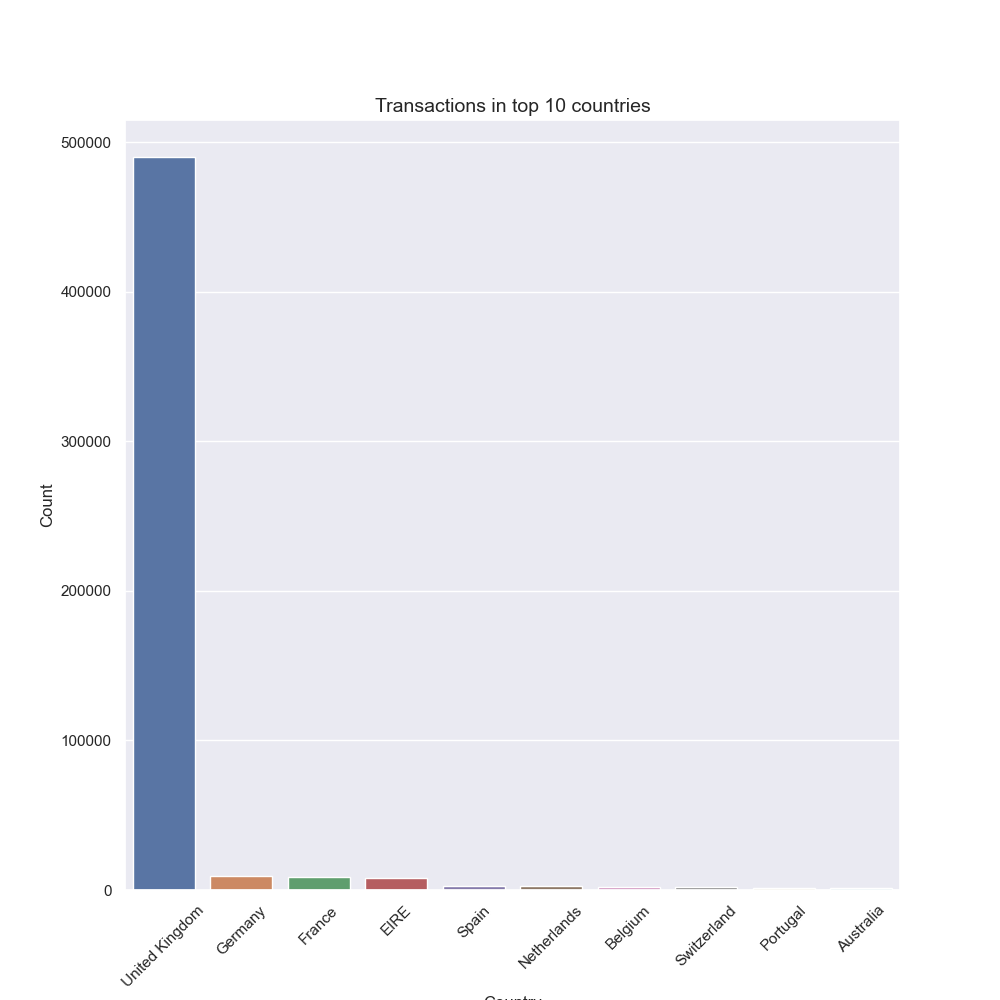

In [125]:
fig, ax = plt.subplots(figsize=(10,10))
country_counts = df_retail['Country'].value_counts()
country_counts=country_counts.reset_index()
country_counts.columns=['Country','Count']
ax=sns.barplot(x='Country', y='Count',data=country_counts.head(10),estimator=max,ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_title('Transactions in top 10 countries', fontsize = 14)
plt.show()

A large majority of orders are from the United Kingdom. Hence, for the purpose of this study, we can safely reject data points belonging to other countries

## Data Preprocessing
**Some insights made so far**:
- There exists 133252 null entries in CustomerID.
- There are 5268 duplicate entries.
- Most of the entries are from the UK.

First, the duplicate entries and entries with Country other than UK will be dropped.

In [118]:
# Removes all duplicates keeping the first instance
df_retail.drop_duplicates(keep='first',inplace=True) 
df_retail.duplicated().sum()

0

In [126]:
# Keeps only entries from the United Kingdom
df_retail=df_retail[df_retail['Country']=='United Kingdom'] 
df_retail['Country'].value_counts()

United Kingdom    490300
Name: Country, dtype: int64

According to the data description, it is said that the InvoiceNo of canceled orders contain the letter 'C' in them. These canceled order entries have to be removed.

In [84]:
# removes all cancelled orders
df_retail = df_retail[~df_retail["InvoiceNo"].str.contains("C", na=False)] 
df_retail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 482479 entries, 0 to 541893
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    482479 non-null  object        
 1   StockCode    482479 non-null  object        
 2   Description  481025 non-null  object        
 3   Quantity     482479 non-null  int64         
 4   InvoiceDate  482479 non-null  datetime64[ns]
 5   UnitPrice    482479 non-null  float64       
 6   CustomerID   349227 non-null  float64       
 7   Country      482479 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [86]:
# Drop rows with null entries in CustomerID
df_retail=df_retail.dropna(subset=['CustomerID'])
df_retail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349227 entries, 0 to 541893
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    349227 non-null  object        
 1   StockCode    349227 non-null  object        
 2   Description  349227 non-null  object        
 3   Quantity     349227 non-null  int64         
 4   InvoiceDate  349227 non-null  datetime64[ns]
 5   UnitPrice    349227 non-null  float64       
 6   CustomerID   349227 non-null  float64       
 7   Country      349227 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 24.0+ MB


In [87]:
# Keep only non negative values of Price and Quantity
df_retail = df_retail[(df_retail['UnitPrice']>0) & (df_retail['Quantity']>0)]
df_retail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349203 entries, 0 to 541893
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    349203 non-null  object        
 1   StockCode    349203 non-null  object        
 2   Description  349203 non-null  object        
 3   Quantity     349203 non-null  int64         
 4   InvoiceDate  349203 non-null  datetime64[ns]
 5   UnitPrice    349203 non-null  float64       
 6   CustomerID   349203 non-null  float64       
 7   Country      349203 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 24.0+ MB


In [88]:
# Calculates amount as product of unit price and Quantity
df_retail['Amount']=df_retail['Quantity']*df_retail['UnitPrice']
df_retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [89]:
# Calculates total monetary value of each customers as sum of Amount of all transactions and stores in new dataframe
monetary=df_retail.groupby('CustomerID')['Amount'].sum()
monetary = monetary.reset_index()
monetary.head()

,CustomerID,Amount
0,12346.0,77183.60
1,12747.0,4196.01
2,12748.0,33053.19
3,12749.0,4090.88
4,12820.0,942.34


In [90]:
# Total number of individual transaction of customers by invoice number
frequency = df_retail.groupby('CustomerID')['InvoiceNo'].count()
frequency = frequency.reset_index()
frequency.head()

,CustomerID,InvoiceNo
0,12346.0,1
1,12747.0,103
2,12748.0,4412
3,12749.0,199
4,12820.0,59


In [91]:
# Number of days between each transaction and last recorded transaction 
df_retail['Latest'] = max(df_retail['InvoiceDate']) - df_retail['InvoiceDate']
df_retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Latest
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:23:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:23:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:23:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:23:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:23:00


In [92]:
# Most recent transaction per customer 
recency = df_retail.groupby('CustomerID')['Latest'].min()
recency = recency.reset_index()
recency.head()

,CustomerID,Latest
0,12346.0,325 days 02:48:00
1,12747.0,1 days 22:15:00
2,12748.0,0 days 00:29:00
3,12749.0,3 days 02:53:00
4,12820.0,2 days 21:37:00


In [93]:
# Remove time from the values
recency['Latest']=recency['Latest'].dt.days
recency.head()

,CustomerID,Latest
0,12346.0,325
1,12747.0,1
2,12748.0,0
3,12749.0,3
4,12820.0,2


In [94]:
# Merge monetary and frequency tables based on CustomerID
rfm = pd.merge(monetary, frequency, on='CustomerID', how='inner')
rfm.head()

,CustomerID,Amount,InvoiceNo
0,12346.0,77183.60,1
1,12747.0,4196.01,103
2,12748.0,33053.19,4412
3,12749.0,4090.88,199
4,12820.0,942.34,59


In [95]:
# Merge monetary and frequency table with recency table based on CustomerID and change column name
rfm = pd.merge(rfm, recency, on='CustomerID', how='inner')
rfm.columns=['CustomerID','Monetary','Frequency','Recency']
rfm.head()

,CustomerID,Monetary,Frequency,Recency
0,12346.0,77183.60,1,325
1,12747.0,4196.01,103,1
2,12748.0,33053.19,4412,0
3,12749.0,4090.88,199,3
4,12820.0,942.34,59,2


In [96]:
# CustomerID is stored as string
rfm['CustomerID']=rfm['CustomerID'].astype(str)

In [97]:
# Statistical description of dataframe
rfm.describe()

,Monetary,Frequency,Recency
count,3920.000000,3920.000000,3920.000000
mean,1858.424654,89.082398,91.208418
std,7478.631256,214.034542,99.533854
min,3.750000,1.000000,0.000000
25%,298.185000,17.000000,17.000000
50%,644.975000,40.000000,50.000000
75%,1571.285000,98.000000,142.000000
max,259657.300000,7676.000000,373.000000


In [98]:
# Set upper limit and lower limit at 3 standard deviations from the mean
m_mean=rfm['Monetary'].mean()
m_sd=rfm['Monetary'].std()
upperl_m=m_mean+3*m_sd
lowerl_m=m_mean-3*m_sd
upperl_m,lowerl_m,m_mean,m_sd

(24294.31842285217, -20577.46911468891, 1858.4246540816325, 7478.631256256846)

In [99]:
# Remove outliers
rfm=rfm[(rfm['Monetary']>lowerl_m) & (rfm['Monetary']<upperl_m)] 
rfm.describe()

,Monetary,Frequency,Recency
count,3887.000000,3887.000000,3887.000000
mean,1352.646929,81.866478,91.746077
std,2083.818453,128.558731,99.563190
min,3.750000,1.000000,0.000000
25%,295.465000,16.000000,17.000000
50%,638.050000,40.000000,50.000000
75%,1533.230000,97.000000,143.000000
max,21086.300000,2677.000000,373.000000


In [100]:
# Repeat for frequency
f_mean=rfm['Frequency'].mean()
f_sd=rfm['Frequency'].std()
upperl_f=f_mean+3*f_sd
lowerl_f=f_mean-3*f_sd
upperl_f,lowerl_f,f_mean,f_sd

(467.54267109615193,
 -303.80971508894845,
 81.86647800360176,
 128.55873103085005)

In [101]:
rfm=rfm[(rfm['Frequency']>lowerl_f) & (rfm['Frequency']<upperl_f)] 
rfm.describe()

,Monetary,Frequency,Recency
count,3816.000000,3816.000000,3816.000000
mean,1252.649113,69.819969,93.250262
std,1875.664680,82.122428,99.832045
min,3.750000,1.000000,0.000000
25%,290.390000,16.000000,18.000000
50%,622.130000,39.000000,51.000000
75%,1445.280000,91.000000,147.000000
max,21086.300000,467.000000,373.000000


In [102]:
# Repeat for Recency
r_mean=rfm['Recency'].mean()
r_sd=rfm['Recency'].std()
upperl_r=r_mean+3*r_sd
lowerl_r=r_mean-3*r_sd
upperl_r,lowerl_r,r_mean,r_sd

(392.7463972429747, -206.24587313396, 93.25026205450733, 99.83204506282244)

In [103]:
rfm.info()
rfm.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3816 entries, 1 to 3919
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  3816 non-null   object 
 1   Monetary    3816 non-null   float64
 2   Frequency   3816 non-null   int64  
 3   Recency     3816 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 149.1+ KB


,CustomerID,Monetary,Frequency,Recency
1,12747.0,4196.01,103,1
3,12749.0,4090.88,199,3
4,12820.0,942.34,59,2
5,12821.0,92.72,6,213
6,12822.0,948.88,46,70


In [104]:
# Rescaling the attributes
rfm_reshaped = rfm[['Monetary', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_reshaped)
rfm_df_scaled.shape

(3816, 3)

In [105]:
# Make dataframe and name colums
rfm_scaled = pd.DataFrame(rfm_df_scaled)
rfm_scaled.columns = ['Monetary', 'Frequency', 'Recency']
rfm_scaled.head()

,Monetary,Frequency,Recency
0,1.569442,0.404084,-0.924176
1,1.513385,1.573224,-0.904139
2,-0.165461,-0.131771,-0.914158
3,-0.618491,-0.777234,1.199669
4,-0.161974,-0.290092,-0.232924


In [106]:
# Calculate SSE to find optimum number of clusters
sse = []
k_rng = range(1,11)
for k in k_rng:
    km = KMeans(n_clusters=k,init='k-means++')
    km.fit(rfm_scaled[['Monetary', 'Frequency', 'Recency']])
    sse.append(km.inertia_)

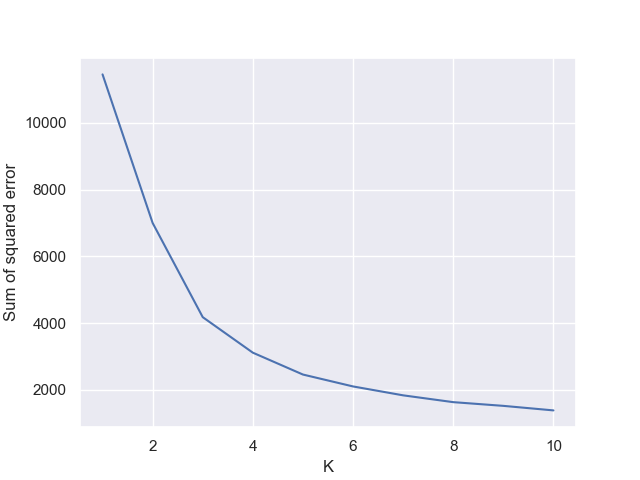

In [107]:
# Plot elbow plot to find k
fig, ax = plt.subplots()
plt.xlabel('K')
plt.ylabel('Sum of squared error')
plt.plot(k_rng,sse)
plt.show()

In [108]:
# Perform K-Means clustering on normalized data
km = KMeans(n_clusters=3)
y_predicted = km.fit_predict(rfm_scaled[['Monetary', 'Frequency', 'Recency']])
y_predicted

array([0, 0, 1, ..., 2, 1, 1])

In [109]:
# Display cluster centers
km.cluster_centers_

array([[ 1.8409755 ,  2.06812236, -0.69439667],
       [-0.18159141, -0.18994013, -0.47922416],
       [-0.45152509, -0.54205644,  1.52708108]])

In [110]:
# Add clusters to dataset
rfm_scaled['Cluster']=y_predicted
rfm_scaled.head()

,Monetary,Frequency,Recency,Cluster
0,1.569442,0.404084,-0.924176,0
1,1.513385,1.573224,-0.904139,0
2,-0.165461,-0.131771,-0.914158,1
3,-0.618491,-0.777234,1.199669,2
4,-0.161974,-0.290092,-0.232924,1


In [111]:
rfm1=rfm_scaled[rfm_scaled['Cluster']==0]
rfm2=rfm_scaled[rfm_scaled['Cluster']==1]
rfm3=rfm_scaled[rfm_scaled['Cluster']==2]

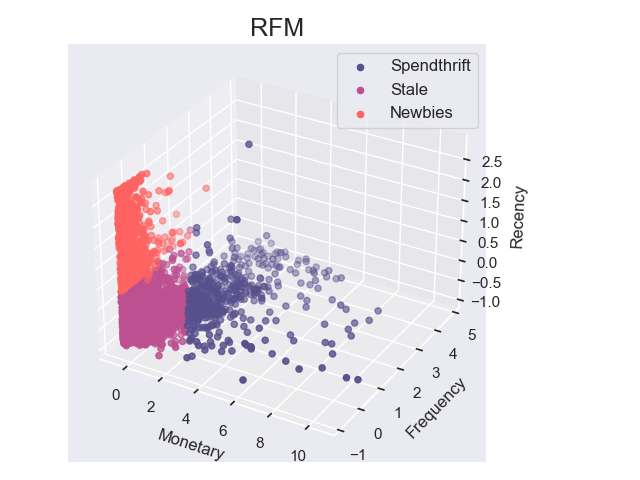

In [112]:
sns.set(style = "darkgrid")
kplot = plt.axes(projection = '3d')
kplot.scatter3D(rfm1.Monetary, rfm1.Frequency, rfm1.Recency, c='#58508d', label = 'Spendthrift')
kplot.scatter3D(rfm2.Monetary, rfm2.Frequency, rfm2.Recency, c='#bc5090', label = 'Stale')
kplot.scatter3D(rfm3.Monetary, rfm3.Frequency, rfm3.Recency, c='#ff6361', label = 'Newbies')
kplot.set_xlabel("Monetary",fontsize=12)
kplot.set_ylabel("Frequency",fontsize=12)
kplot.set_zlabel("Recency",fontsize=12)
plt.title("RFM",fontsize=18)
plt.legend(bbox_to_anchor=(1.0,1.0),prop={'size': 12})
plt.tight_layout()
plt.show()